#### The goal of this notebook is to check the performence of the model trained on augmented data, with and without post processing.

In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset
from ImageDataset import *
from unet import *
from loss import *
import os
import zipfile
from helper import *
import matplotlib.pyplot as plt

In [2]:
#Unzip data.
#It is useful when we want to run the code on Google Colab.
data_path = 'data.zip'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()


In [2]:
TRAIN_IMAGES = 'data/training/images/'
GROUNDTRUTH = 'data/training/groundtruth/'
TEST_IMAGES = 'data/test_set_images/'
AUG_IMG_PATH= 'data/Augmented/Images'
AUG_GT_PATH= 'data/Augmented/Groundtruth'
PREDICTIONS_PATH= 'predictions/'
FOREGROUND_TRESHOLD = 0.25
SPLIT_RATIO = 0.2
BATCH_SIZE = 10
EPOCHS = 150
LR = 1e-3
SEED = 4
WEIGHT_DECAY = 1e-3
WORKERS = 2

In [3]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cpu


In [5]:
# Define image and mask transformations using torchvision.transforms.Compose.
# For both image and mask, convert the input to a PyTorch tensor using transforms.ToTensor().
image_transform = transforms.Compose([
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
# Create an instance of the ImagesDataset class with specified parameters.
dataset = ImagesDataset(
    img_dir=TRAIN_IMAGES,
    gt_dir=GROUNDTRUTH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [7]:
#Display the length of the dataset.
len(dataset)

100

In [9]:
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)

Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


In [8]:
#Split the dataset into training and validation sets.
train_dataset, test_datset= split_data(dataset, 0.2, SEED)

In [ ]:
# Create DataLoader for the training set.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)


In [ ]:
# Create DataLoader for the validation set.
local_test_loader = DataLoader(
    dataset=test_datset,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)


In [ ]:
#This will create rotated images from training and groundtruth images and save them in the
#AUG_IMG_PATH and AUG_GT_PATH folders.
create_augmented_dataset(TRAIN_IMAGES,GROUNDTRUTH,AUG_IMG_PATH,AUG_GT_PATH)

In [18]:
# Create additional dataset for augmented images.
train_dataset2 = ImagesDataset(
    img_dir=AUG_IMG_PATH,
    gt_dir=AUG_GT_PATH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [19]:
#Display the length of newly created dataset (containing the rotated images).
len(train_dataset2)

30

In [21]:
#Concatenate the two datasets and created the augmented dataset.
augmented_dataset= ConcatDataset([train_dataset, train_dataset2])

In [22]:
#Display the length of the augmented dataset.
len(augmented_dataset)

110

In [23]:
#Create DataLoader for the augmented training set.
train_loader_aug= DataLoader(augmented_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=pin_memory)

In [33]:
#Create DataLoader for the validation set (local validation).
local_test_loader= DataLoader(test_datset,num_workers=WORKERS,pin_memory=pin_memory)

In [25]:
#Instantiate the model.
model= UNet().to(device)

In [28]:
#Define the loss function and the optimizer.
criterion = DiceLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [29]:
#Define the learning rate scheduler.
lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=3,
    verbose=True,
)

In [ ]:
#Train the model.
losses= train(model, train_loader_aug, criterion, optimizer, device, EPOCHS,lr_scheduler)

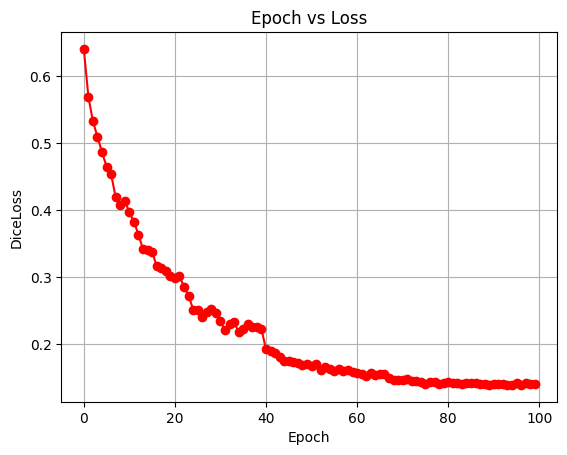

In [32]:
#Plot the loss curve for each epoch of the training.
epochs = [item[0] for item in losses]
losses_ = [item[1] for item in losses]

# Plotting
plt.plot(epochs, losses_, color='red', marker='o', linestyle='-')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('DiceLoss')
plt.grid(True)
plt.show()

In [ ]:
#Local validation.
f1,acc,filenames= predict(model,local_test_loader,device,PREDICTIONS_PATH,FOREGROUND_TRESHOLD)

In [2]:
#Local validation performence results.
print("F1 Score:  ", f1)
print("Accuracy:  ", acc)

F1 Score:   0.8391933721179041
Accuracy:   0.9337771874999999


## Testing and submission

In [15]:
# Define transformation using torchvision.transforms.Compose.
# For testing images, convert the input to a PyTorch tensor using transforms.ToTensor().
test_image_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:
#Create the test set.
test_set = ImagesDataset(
    img_dir=TEST_IMAGES,
    image_transform=test_image_transform,
)

In [17]:
#Create DataLoader for the test set.
test_loader = DataLoader(
    dataset=test_set,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

In [19]:
#Predict the test set.
_,_,filenames= predict(model,test_loader,device,PREDICTIONS_PATH,FOREGROUND_TRESHOLD)

Processing prediction_001.png
Processing prediction_002.png
Processing prediction_003.png
Processing prediction_004.png
Processing prediction_005.png
Processing prediction_006.png
Processing prediction_007.png
Processing prediction_008.png
Processing prediction_009.png
Processing prediction_010.png
Processing prediction_011.png
Processing prediction_012.png
Processing prediction_013.png
Processing prediction_014.png
Processing prediction_015.png
Processing prediction_016.png
Processing prediction_017.png
Processing prediction_018.png
Processing prediction_019.png
Processing prediction_020.png
Processing prediction_021.png
Processing prediction_022.png
Processing prediction_023.png
Processing prediction_024.png
Processing prediction_025.png
Processing prediction_026.png
Processing prediction_027.png
Processing prediction_028.png
Processing prediction_029.png
Processing prediction_030.png
Processing prediction_031.png
Processing prediction_032.png
Processing prediction_033.png
Processing

In [39]:
#Create the submission file.
masks_to_submission('submission.csv',*filenames)

In [40]:
#Save the model.
torch.save(model.state_dict(), 'models/modelAug.pth')

## PostProcessing

In [11]:
#Do some post processing on the predictions and save them in the improved_predictions folder.
process_images('predictions/','improved_predictions/')

In [12]:
#Get the names of improved masks.
image_names = [f for f in os.listdir('improved_predictions') if f.endswith(('.png', '.jpg', '.jpeg'))]

In [13]:
#Create the path for each mask.
filenames= list()
for name in image_names:
    new_name = os.path.join('improved_predictions', name)
    filenames.append(new_name)


In [14]:
#Create the submission file.
masks_to_submission('submission.csv', *filenames)